In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

from src.utility.h5_serializable_file import H5Serializable
import src.utility.utils as utils 
from uncertainties import ufloat
from src.photometry_data import PhotometryData
from src.utility.run_cfg import ErebusRunConfig
from src.erebus import Erebus
from src.utility.utils import bin_data
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ErebusRunConfig.save_schema("../src/schema/run_cfg_schema.json")

In [3]:
lhs1478b = Erebus(ErebusRunConfig.load("./run_cfgs/lhs1478b_joint_fit.yaml"))

Circular orbit: using gaussian prior for t_sec_offset


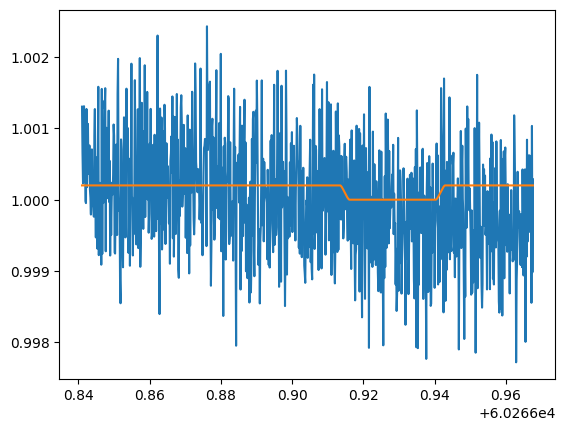

In [4]:
t = lhs1478b.joint_fit.time
f = lhs1478b.joint_fit.raw_flux
mcmc = lhs1478b.joint_fit.mcmc
all_params = np.array([mcmc.params[p].value for p in mcmc.params])[:-1]
physical_params = all_params[:9]
filt = np.array([lhs1478b.joint_fit.get_visit_index_from_time(ti) for ti in t])
visit_filt = filt == 1
model_f = lhs1478b.joint_fit.physical_model(t[visit_filt], *physical_params)
model_f = lhs1478b.joint_fit.physical_model(t[visit_filt], *physical_params)
plt.plot(t[visit_filt], f[visit_filt])
plt.plot(t[visit_filt], model_f)


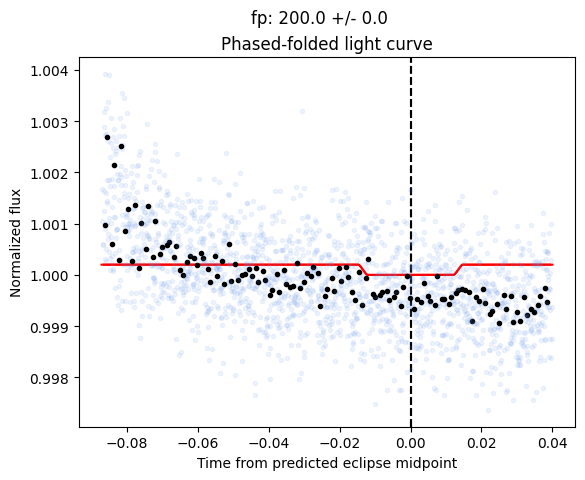

In [13]:
t = lhs1478b.joint_fit.time
f = lhs1478b.joint_fit.raw_flux

filt = np.array([lhs1478b.joint_fit.get_visit_index_from_time(ti) for ti in t])

def plot_visit(ind, actual_results):
	if actual_results:
		res = lhs1478b.joint_fit.results
		all_params = [res[k].nominal_value for k in res][:-1]
		fp_err = res['fp'].std_dev
	else:
		mcmc = lhs1478b.joint_fit.mcmc
		all_params = np.array([mcmc.params[p].value for p in mcmc.params])[:-1]
		fp_err = 0.0
	physical_params = all_params[:9]

	f_model = lhs1478b.joint_fit.fit_method(t, *all_params)
	
	t_sec_offset = all_params[0]
	fp = all_params[1]
	yerr = all_params[8]

	visit_filt = filt == ind

	visit_t = t[visit_filt]
	visit_f = f[visit_filt]
	visit_model_f = f_model[visit_filt]
	visit_phys_f = lhs1478b.joint_fit.physical_model(t[visit_filt], *physical_params)
	visit_sys = visit_model_f / visit_phys_f

	t_sec = lhs1478b.joint_fit.get_predicted_t_sec_of_visit(ind).nominal_value
	visit_t = visit_t - lhs1478b.joint_fit.starting_times[ind]
	
	x = visit_t - t_sec
	y = visit_f / visit_sys

	bin_size = 14
	binned_x, _ = bin_data(x, bin_size)
	binned_y, _ = bin_data(y, bin_size)

	plt.errorbar(x, y, yerr=yerr, marker = '.', linestyle= '', alpha=0.1, color='cornflowerblue')
	plt.errorbar(binned_x, binned_y, yerr=yerr/np.sqrt(bin_size), marker = '.', linestyle= '', color='black')
	plt.suptitle(f"fp: {fp*1e6:0.1f} +/- {fp_err*1e6:0.1f}")
	plt.plot(x, visit_phys_f, color='red')
	plt.axvline(t_sec_offset, color='black', linestyle='--')
	plt.ylabel("Normalized flux")
	plt.xlabel("Time from predicted eclipse midpoint")

plot_visit(0, False)
plot_visit(1, False)
plt.title("Phased-folded light curve")
plt.show()

In [6]:
lhs1478b.run()

Joint fit already ran


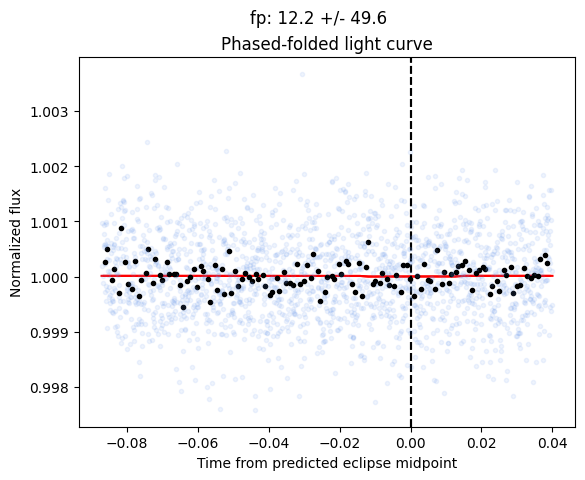

In [14]:
plot_visit(0, True)
plot_visit(1, True)
plt.title("Phased-folded light curve")
plt.show()